In [1]:
from google.colab import drive

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import numpy as np

In [5]:
from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
!ls "drive/MyDrive/Colab Notebooks/Youtube Practise/Python for Data Science Course"

ab_test_click_data.csv	CaseStudy_AB_testing.ipynb


In [7]:
df=pd.read_csv("drive/MyDrive/Colab Notebooks/Youtube Practise/Python for Data Science Course/ab_test_click_data.csv")

In [8]:
df.head()

,user_id,click,group,timestamp
0,1,1,exp,2024-01-01 00:00:00
1,2,0,exp,2024-01-01 00:01:00
2,3,1,exp,2024-01-01 00:02:00
3,4,0,exp,2024-01-01 00:03:00
4,5,1,exp,2024-01-01 00:04:00


In [9]:
df.describe()

,user_id,click
count,20000.000000,20000.000000
mean,10000.500000,0.405250
std,5773.647028,0.490953
min,1.000000,0.000000
25%,5000.750000,0.000000
50%,10000.500000,0.000000
75%,15000.250000,1.000000
max,20000.000000,1.000000


In [10]:
df.groupby("click").sum("click")

,user_id
click,
0,139615577
1,60394423


In [11]:
palette={0:'yellow',1:'black'}

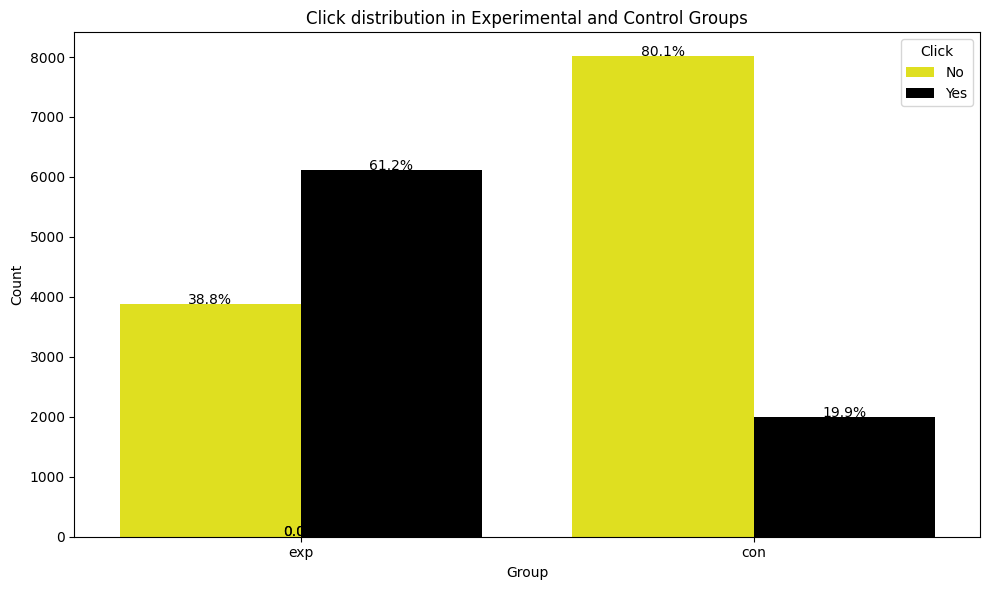

In [12]:
plt.figure(figsize=(10,6))
ax=sns.countplot(x='group',hue='click',data=df,palette=palette)
plt.title('Click distribution in Experimental and Control Groups')
plt.xlabel('Group')
plt.ylabel('Count')
plt.legend(title="Click",labels=['No','Yes'])

group_counts=df.groupby(['group']).size()
group_click_counts=df.groupby(['group','click']).size().reset_index(name='count')

for p in ax.patches:
  height=p.get_height()
  group='exp' if p.get_x() else 'con'
  click=1 if p.get_x() % 1 > 0.5 else 0
  total=group_counts.loc[group]
  percentage=100*height / total
  ax.text(p.get_x()+p.get_width()/2.,height+5,f'{percentage:.1f}%',ha="center",color="black",fontsize=10)
plt.tight_layout()
plt.show()

In [13]:
#Parameters of the model from Power Analysis

In [14]:
alpha=0.05
print("Alpha significance level is:",alpha)
delta=0.1
print("Delta minimum detectable effect is:",delta)

Alpha significance level is: 0.05
Delta minimum detectable effect is: 0.1


In [15]:
#Calculating total number of clicks per group by summing clicks
X_con=df.groupby("group")["click"].sum().loc["con"]
X_exp=df.groupby("group")["click"].sum().loc["exp"]

print(df.groupby("group")["click"].sum())
print("Number of clicks in control:",X_con)
print("Number of clicks in experimental:",X_exp)

group
con    1989
exp    6116
Name: click, dtype: int64
Number of clicks in control: 1989
Number of clicks in experimental: 6116


In [16]:
N_exp = 10000
N_con = 10000

In [17]:
#Calculating Poolde Estimates for clicks per group
p_con_hat=X_con/N_con
p_exp_hat=X_exp/N_exp


print("Click probability in Control Group:",p_con_hat)
print("Click probability in Experimental Group:",p_exp_hat)

Click probability in Control Group: 0.1989
Click probability in Experimental Group: 0.6116


In [18]:
p_pooled_hat=(X_con+X_exp)/(N_con+N_exp)

In [19]:
#Calculating the Pooled Variance

In [20]:
pooled_variance=p_pooled_hat*(1-p_pooled_hat)*(1/N_con+1/N_exp)

In [21]:
print("p_pooled_hat:",p_pooled_hat)
print("pooled_variance:",pooled_variance)

p_pooled_hat: 0.40525
pooled_variance: 4.82044875e-05


In [22]:
#Calculating Standard Error and Test Statistics

In [23]:
SE=np.sqrt(pooled_variance)
print("Standard Error:",SE)

Test_stat=(p_con_hat - p_exp_hat)/SE
print("Test Statistics for 2-sample Z-test is:",Test_stat)

Z_crit=norm.ppf(1-alpha/2)
print("Z critical value from Standard Normal Distribution:",Z_crit)



Standard Error: 0.006942945160376826
Test Statistics for 2-sample Z-test is: -59.44163326469381
Z critical value from Standard Normal Distribution: 1.959963984540054


In [24]:
#Calculating p_values of the Z-Test

In [25]:
p_value=2*norm.sf(abs(Test_stat))
def is_statistical_significance(p_value,aplha):
  print(f"P-value of the 2-sample Z-test:{round(p_value,3)}")
  if p_value < alpha:
    print("ok")
  else:
    print("nok")

In [26]:
is_statistical_significance(p_value,alpha)

P-value of the 2-sample Z-test:0.0
ok


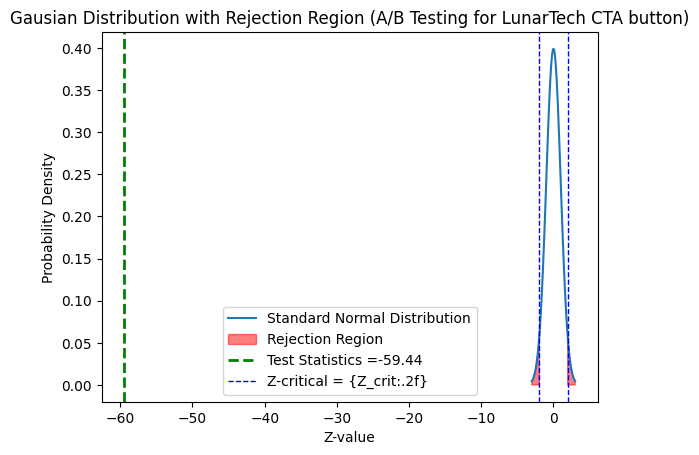

In [27]:
#Parameters for standard normal distribution
mu=0
sigma=1
x=np.linspace(mu-3*sigma,mu+3*sigma,100)
y=norm.pdf(x,mu,sigma)


plt.plot(x,y,label="Standard Normal Distribution")
plt.fill_between(x,y,where=(x > Z_crit) | (x < - Z_crit),color='red',alpha=0.5,label='Rejection Region')
plt.axvline(Test_stat,color='green',linestyle='dashed',linewidth=2,label=f'Test Statistics ={Test_stat:.2f}')
plt.axvline(Z_crit,color="blue",linestyle='dashed',linewidth=1,label='Z-critical = {Z_crit:.2f}')
plt.axvline(-Z_crit,color='blue',linestyle='dashed',linewidth=1)

plt.xlabel('Z-value')
plt.ylabel('Probability Density')
plt.title('Gausian Distribution with Rejection Region (A/B Testing for LunarTech CTA button)')
plt.legend()

plt.show()

In [28]:
#Calculating Confidence Interval of the Test
CI=[
    round((p_exp_hat-p_con_hat)-SE*Z_crit,3),#Lower bound
    round((p_exp_hat-p_con_hat)+SE*Z_crit,3)#Upper bound
]
print("Confidence Interval of the 2 sample Z-test is:",CI)


Confidence Interval of the 2 sample Z-test is: [0.399, 0.426]


In [29]:
#Testing for Practical significance in A/B Testing

In [30]:
def is_Practically_significant(delta,CI_95):
  lower_bound_CI=CI_95[0]
  if lower_bound_CI >= delta:
    print("Ok")
    return True
  else:
    print("NOK")
    return False
delta=0.05
CI_95=(0.04,0.06)
significance=is_Practically_significant(delta,CI_95)

NOK


In [32]:
!ls "drive/MyDrive/Colab Notebooks/Youtube Practise/Python for Data Science Course"

ab_test_click_data.csv	CaseStudy_AB_testing.ipynb  train.csv


Superstore Data Analysis

In [33]:
df=pd.read_csv('drive/MyDrive/Colab Notebooks/Youtube Practise/Python for Data Science Course/train.csv')

In [34]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


In [35]:
df.describe()


,Row ID,Postal Code,Sales
count,9800.000000,9789.000000,9800.000000
mean,4900.500000,55273.322403,230.769059
std,2829.160653,32041.223413,626.651875
min,1.000000,1040.000000,0.444000
25%,2450.750000,23223.000000,17.248000
50%,4900.500000,58103.000000,54.490000
75%,7350.250000,90008.000000,210.605000
max,9800.000000,99301.000000,22638.480000


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9800 non-null   int64  
 1   Order ID       9800 non-null   object 
 2   Order Date     9800 non-null   object 
 3   Ship Date      9800 non-null   object 
 4   Ship Mode      9800 non-null   object 
 5   Customer ID    9800 non-null   object 
 6   Customer Name  9800 non-null   object 
 7   Segment        9800 non-null   object 
 8   Country        9800 non-null   object 
 9   City           9800 non-null   object 
 10  State          9800 non-null   object 
 11  Postal Code    9789 non-null   float64
 12  Region         9800 non-null   object 
 13  Product ID     9800 non-null   object 
 14  Category       9800 non-null   object 
 15  Sub-Category   9800 non-null   object 
 16  Product Name   9800 non-null   object 
 17  Sales          9800 non-null   float64
dtypes: float

In [38]:
df["Postal Code"].fillna(0,inplace=True)

In [39]:
df["Postal Code"]=df["Postal Code"].astype(int)

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9800 non-null   int64  
 1   Order ID       9800 non-null   object 
 2   Order Date     9800 non-null   object 
 3   Ship Date      9800 non-null   object 
 4   Ship Mode      9800 non-null   object 
 5   Customer ID    9800 non-null   object 
 6   Customer Name  9800 non-null   object 
 7   Segment        9800 non-null   object 
 8   Country        9800 non-null   object 
 9   City           9800 non-null   object 
 10  State          9800 non-null   object 
 11  Postal Code    9800 non-null   int64  
 12  Region         9800 non-null   object 
 13  Product ID     9800 non-null   object 
 14  Category       9800 non-null   object 
 15  Sub-Category   9800 non-null   object 
 16  Product Name   9800 non-null   object 
 17  Sales          9800 non-null   float64
dtypes: float

In [42]:
if df.duplicated().sum() > 0:
  print("Duplicate exists")
else:
  print("Don't exists")

Don't exists


In [43]:
types_of_customers=df["Segment"].unique()
print("types_of_customers:",types_of_customers)

types_of_customers: ['Consumer' 'Corporate' 'Home Office']


In [44]:
number_of_customers=df['Segment'].value_counts().reset_index()
print("number_of_customers:",number_of_customers)

number_of_customers:        Segment  count
0     Consumer   5101
1    Corporate   2953
2  Home Office   1746


In [45]:
number_of_customers=number_of_customers.rename(columns={'Segment':'Type Of Customer'})
print("number_of_customers:",number_of_customers)

number_of_customers:   Type Of Customer  count
0         Consumer   5101
1        Corporate   2953
2      Home Office   1746


([<matplotlib.patches.Wedge at 0x7c8d6f547130>,
 [Text(-0.07082911608159113, 1.0977172843292122, 'Consumer'),
  Text(-0.5228074775852011, -0.9678183411059121, 'Corporate'),
  Text(0.9321462996405261, -0.584040474681742, 'Home Office')],
 [Text(-0.03863406331723152, 0.5987548823613884, '52.1'),
  Text(-0.28516771504647326, -0.5279009133304975, '30.1'),
  Text(0.5084434361675596, -0.31856753164458657, '17.8')])

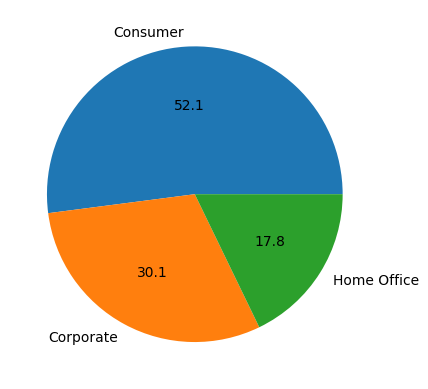

In [46]:
plt.pie(number_of_customers['count'],labels=number_of_customers['Type Of Customer'],autopct='%1.1f')

  Type Of Customer   Total Sales
0         Consumer  1.148061e+06
1        Corporate  6.884941e+05
2      Home Office  4.249822e+05


<BarContainer object of 3 artists>

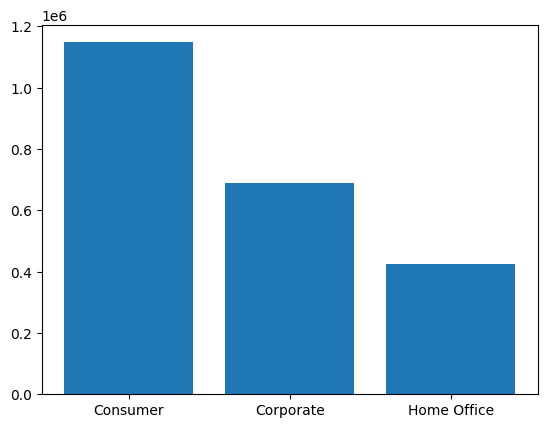

In [47]:
sales_per_segment = df.groupby('Segment')['Sales'].sum().reset_index()
sales_per_segment = sales_per_segment.rename(columns={'Segment' : 'Type Of Customer', 'Sales' : 'Total Sales'})

print(sales_per_segment)

plt.bar(sales_per_segment['Type Of Customer'], sales_per_segment['Total Sales'])

([<matplotlib.patches.Wedge at 0x7c8d6f6d6830>,
 [Text(-0.02642083976554102, 1.0996826538715994, 'Consumer'),
  Text(-0.5902005886829921, -0.9282581888236967, 'Corporate'),
  Text(0.913814451312435, -0.612326014940206, 'Home Office')],
 [Text(-0.014411367144840556, 0.5998269021117814, '50.8%'),
  Text(-0.3219275938270865, -0.5063226484492891, '30.4%'),
  Text(0.49844424617041905, -0.33399600814920327, '18.8%')])

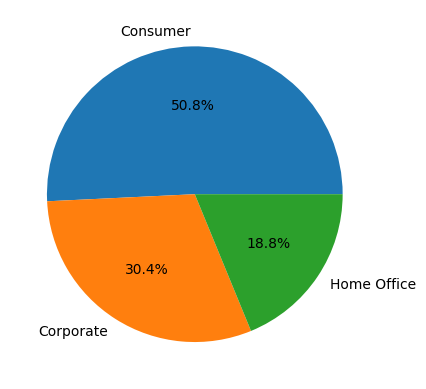

In [48]:
plt.pie(sales_per_segment['Total Sales'], labels=sales_per_segment['Type Of Customer'], autopct='%1.1f%%')


In [49]:
customers_order_frequency = df.groupby(['Customer ID', 'Customer Name', 'Segment'])['Order ID'].count().reset_index()


In [50]:
customers_order_frequency.rename(columns={'Order ID' : 'Total Orders'}, inplace = True)


In [51]:
repeat_customers = customers_order_frequency[customers_order_frequency['Total Orders'] >= 1]


In [52]:
repeat_customers_sorted = repeat_customers.sort_values(by='Total Orders', ascending = False)


In [53]:
print(repeat_customers_sorted.head(12).reset_index(drop=True))


   Customer ID        Customer Name      Segment  Total Orders
0     WB-21850        William Brown     Consumer            35
1     PP-18955           Paul Prost  Home Office            34
2     MA-17560         Matt Abelman  Home Office            34
3     JL-15835             John Lee     Consumer            33
4     CK-12205  Chloris Kastensmidt     Consumer            32
5     SV-20365          Seth Vernon     Consumer            32
6     JD-15895     Jonathan Doherty    Corporate            32
7     AP-10915       Arthur Prichep     Consumer            31
8     ZC-21910     Zuschuss Carroll     Consumer            31
9     EP-13915           Emily Phan     Consumer            31
10    LC-16870        Lena Cacioppo     Consumer            30
11    Dp-13240          Dean percer  Home Office            29


In [54]:
customer_sales = df.groupby(['Customer ID', 'Customer Name', 'Segment'])['Sales'].sum().reset_index()


In [55]:
top_spenders = customer_sales.sort_values(by='Sales', ascending=False)


In [56]:
print(top_spenders.head(12).reset_index(drop=True))


   Customer ID       Customer Name      Segment      Sales
0     SM-20320         Sean Miller  Home Office  25043.050
1     TC-20980        Tamara Chand    Corporate  19052.218
2     RB-19360        Raymond Buch     Consumer  15117.339
3     TA-21385        Tom Ashbrook  Home Office  14595.620
4     AB-10105       Adrian Barton     Consumer  14473.571
5     KL-16645        Ken Lonsdale     Consumer  14175.229
6     SC-20095        Sanjit Chand     Consumer  14142.334
7     HL-15040        Hunter Lopez     Consumer  12873.298
8     SE-20110        Sanjit Engle     Consumer  12209.438
9     CC-12370  Christopher Conant     Consumer  12129.072
10    TS-21370        Todd Sumrall    Corporate  11891.751
11    GT-14710           Greg Tran     Consumer  11820.120


In [57]:
types_of_customers = df['Ship Mode'].unique()
print(types_of_customers)

['Second Class' 'Standard Class' 'First Class' 'Same Day']


In [58]:
shipping_model = df['Ship Mode'].value_counts().reset_index()
shipping_model = shipping_model.rename(columns={'index':'Use Frequency', 'Ship Mode':'Mode Of Shipment', 'count' : 'Use Frequency'})
print(shipping_model)

  Mode Of Shipment  Use Frequency
0   Standard Class           5859
1     Second Class           1902
2      First Class           1501
3         Same Day            538


([<matplotlib.patches.Wedge at 0x7c8d709a44f0>,
 [Text(-0.3328682142840549, 1.0484267985507356, 'Standard Class'),
  Text(-0.3732753555364641, -1.0347296791670404, 'Second Class'),
  Text(0.7455146923475287, -0.8088311588298078, 'First Class'),
  Text(1.083680807320627, -0.18877475425732734, 'Same Day')],
 [Text(-0.18156448051857538, 0.5718691628458558, '59.8%'),
  Text(-0.20360473938352586, -0.5643980068183856, '19.4%'),
  Text(0.4066443776441065, -0.44118063208898606, '15.3%'),
  Text(0.5910986221748874, -0.102968047776724, '5.5%')])

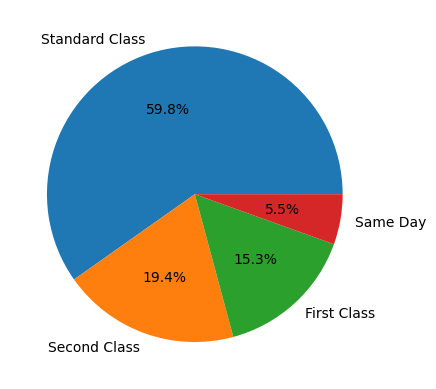

In [59]:
plt.pie(shipping_model['Use Frequency'], labels=shipping_model['Mode Of Shipment'], autopct='%1.1f%%')


In [60]:

state = df['State'].value_counts().reset_index()
state = state.rename(columns={'index':'State', 'State':'Number Of Customers'})
print(state.head(20))

   Number Of Customers  count
0           California   1946
1             New York   1097
2                Texas    973
3         Pennsylvania    582
4           Washington    504
5             Illinois    483
6                 Ohio    454
7              Florida    373
8             Michigan    253
9       North Carolina    247
10            Virginia    224
11             Arizona    223
12           Tennessee    183
13            Colorado    179
14             Georgia    177
15            Kentucky    137
16             Indiana    135
17       Massachusetts    135
18              Oregon    122
19          New Jersey    122


In [61]:
city = df['City'].value_counts().reset_index()
print(city.head(25))


             City  count
0   New York City    891
1     Los Angeles    728
2    Philadelphia    532
3   San Francisco    500
4         Seattle    426
5         Houston    374
6         Chicago    308
7        Columbus    221
8       San Diego    170
9     Springfield    161
10         Dallas    156
11   Jacksonville    125
12        Detroit    115
13         Newark     92
14        Jackson     82
15       Columbia     81
16       Richmond     81
17         Aurora     68
18        Phoenix     63
19      Arlington     60
20    San Antonio     59
21          Miami     56
22     Louisville     54
23      Rochester     53
24     Long Beach     52


In [62]:
state_sales = df.groupby(['State'])['Sales'].sum().reset_index()

In [63]:
top_sales = state_sales.sort_values(by='Sales', ascending=False)

In [64]:

print(top_sales.head(10).reset_index(drop=True))


          State        Sales
0    California  446306.4635
1      New York  306361.1470
2         Texas  168572.5322
3    Washington  135206.8500
4  Pennsylvania  116276.6500
5       Florida   88436.5320
6      Illinois   79236.5170
7      Michigan   76136.0740
8          Ohio   75130.3500
9      Virginia   70636.7200


In [65]:
city_sales = df.groupby(['City'])['Sales'].sum().reset_index()
top_city_sales = city_sales.sort_values (by='Sales', ascending=False)
print(top_city_sales.head(10).reset_index(drop=True))

            City        Sales
0  New York City  252462.5470
1    Los Angeles  173420.1810
2        Seattle  116106.3220
3  San Francisco  109041.1200
4   Philadelphia  108841.7490
5        Houston   63956.1428
6        Chicago   47820.1330
7      San Diego   47521.0290
8   Jacksonville   44713.1830
9        Detroit   42446.9440


In [66]:
state_city_sales = df.groupby(['State', 'City'])['Sales'].sum().reset_index()
print(state_city_sales.head(20))

      State           City      Sales
0   Alabama         Auburn   1766.830
1   Alabama        Decatur   3374.820
2   Alabama       Florence   1997.350
3   Alabama         Hoover    525.850
4   Alabama     Huntsville   2484.370
5   Alabama         Mobile   5462.990
6   Alabama     Montgomery   3722.730
7   Alabama     Tuscaloosa    175.700
8   Arizona       Avondale    946.808
9   Arizona  Bullhead City     22.288
10  Arizona       Chandler   1067.403
11  Arizona        Gilbert   4172.382
12  Arizona       Glendale   2917.865
13  Arizona           Mesa   4037.740
14  Arizona         Peoria   1341.352
15  Arizona        Phoenix  11000.257
16  Arizona     Scottsdale   1466.307
17  Arizona   Sierra Vista     76.072
18  Arizona          Tempe   1070.302
19  Arizona         Tucson   6313.016


In [67]:
products = df['Category'].unique()
print(products)

['Furniture' 'Office Supplies' 'Technology']


In [68]:
product_subcategory = df['Sub-Category'].unique()
print(product_subcategory)

['Bookcases' 'Chairs' 'Labels' 'Tables' 'Storage' 'Furnishings' 'Art'
 'Phones' 'Binders' 'Appliances' 'Paper' 'Accessories' 'Envelopes'
 'Fasteners' 'Supplies' 'Machines' 'Copiers']


In [69]:
subcategory_count = df.groupby('Category')['Sub-Category'].nunique().reset_index()
subcategory_count = subcategory_count.sort_values(by='Sub-Category', ascending = False)
print(subcategory_count)

          Category  Sub-Category
1  Office Supplies             9
0        Furniture             4
2       Technology             4


In [70]:
subcategory_count_sales = df.groupby(['Category', 'Sub-Category'])['Sales'].sum().reset_index()
subcategory_count_sales = subcategory_count_sales.sort_values(by='Sales', ascending = False)

In [71]:
print(subcategory_count_sales)

           Category Sub-Category        Sales
16       Technology       Phones  327782.4480
1         Furniture       Chairs  322822.7310
11  Office Supplies      Storage  219343.3920
3         Furniture       Tables  202810.6280
6   Office Supplies      Binders  200028.7850
15       Technology     Machines  189238.6310
13       Technology  Accessories  164186.7000
14       Technology      Copiers  146248.0940
0         Furniture    Bookcases  113813.1987
4   Office Supplies   Appliances  104618.4030
2         Furniture  Furnishings   89212.0180
10  Office Supplies        Paper   76828.3040
12  Office Supplies     Supplies   46420.3080
5   Office Supplies          Art   26705.4100
7   Office Supplies    Envelopes   16128.0460
9   Office Supplies       Labels   12347.7260
8   Office Supplies    Fasteners    3001.9600


In [72]:
product_category = df.groupby(['Category'])['Sales'].sum().reset_index()
top_product_category = product_category.sort_values(by='Sales', ascending = False)
print(top_product_category.reset_index(drop=True))

          Category        Sales
0       Technology  827455.8730
1        Furniture  728658.5757
2  Office Supplies  705422.3340


([<matplotlib.patches.Wedge at 0x7c8d709eb1f0>,
 [Text(0.4498857223734124, 1.003794220348251, 'Technology'),
  Text(-1.0842321085760298, -0.18558215090028554, 'Furniture'),
  Text(0.6127880326006169, -0.9135046946247543, 'Office Supplies')],
 [Text(0.24539221220367946, 0.547524120189955, '36.6%'),
  Text(-0.5913993319505617, -0.1012266277637921, '32.2%'),
  Text(0.3342480177821546, -0.4982752879771386, '31.2%')])

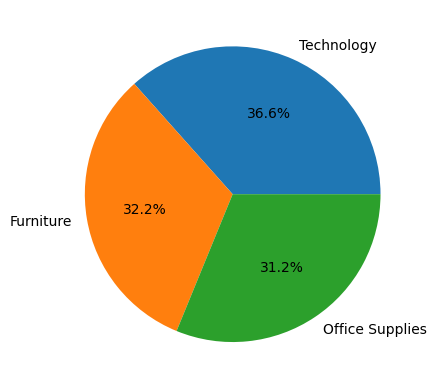

In [73]:
plt.pie(top_product_category['Sales'], labels=top_product_category['Category'], autopct='%1.1f%%')

<BarContainer object of 17 artists>

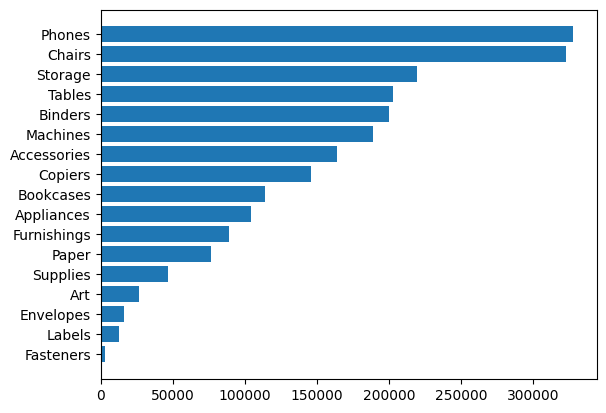

In [74]:

subcategory_count_sales = subcategory_count_sales.sort_values(by='Sales', ascending = True)
plt.barh(subcategory_count_sales['Sub-Category'], subcategory_count_sales['Sales'])

In [75]:
df['Order Date'] = pd.to_datetime(df['Order Date'], dayfirst = True)
yearly_sales = df.groupby(df['Order Date'].dt.year)['Sales'].sum()
yearly_sales = yearly_sales.reset_index()
yearly_sales = yearly_sales.rename(columns={'Order Date' : 'Year', 'Sales': 'Total Sales'})

print (yearly_sales)


   Year  Total Sales
0  2015  479856.2081
1  2016  459436.0054
2  2017  600192.5500
3  2018  722052.0192


<BarContainer object of 4 artists>

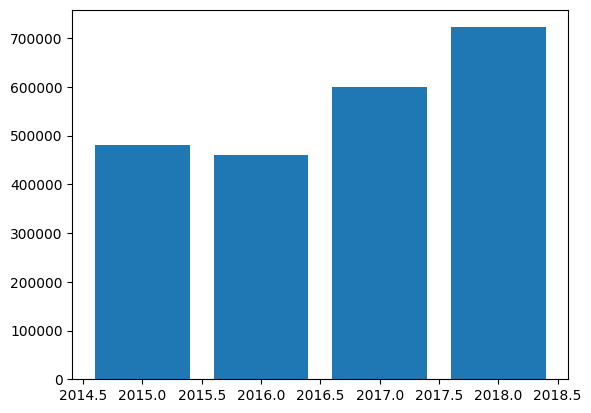

In [76]:
plt.bar(yearly_sales['Year'], yearly_sales['Total Sales'])

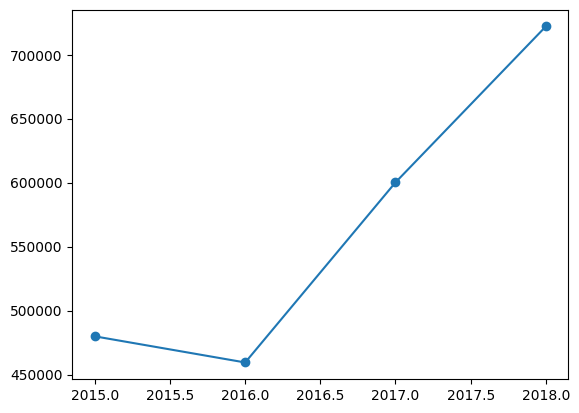

In [77]:
plt.plot(yearly_sales['Year'], yearly_sales['Total Sales'], marker='o', linestyle='-')

In [78]:
df['Order Date'] = pd.to_datetime(df['Order Date'], dayfirst=True)
year_sales = df[df['Order Date'].dt.year == 2018]
quarterly_sales = year_sales.resample('Q', on='Order Date')['Sales'].sum()
quarterly_sales = quarterly_sales.reset_index()
quarterly_sales = quarterly_sales.rename(columns = {'Order Date': 'Quarter', 'Sales' : 'Total Sales'})
print(quarterly_sales)

     Quarter  Total Sales
0 2018-03-31  122260.8842
1 2018-06-30  127558.6200
2 2018-09-30  193815.8400
3 2018-12-31  278416.6750


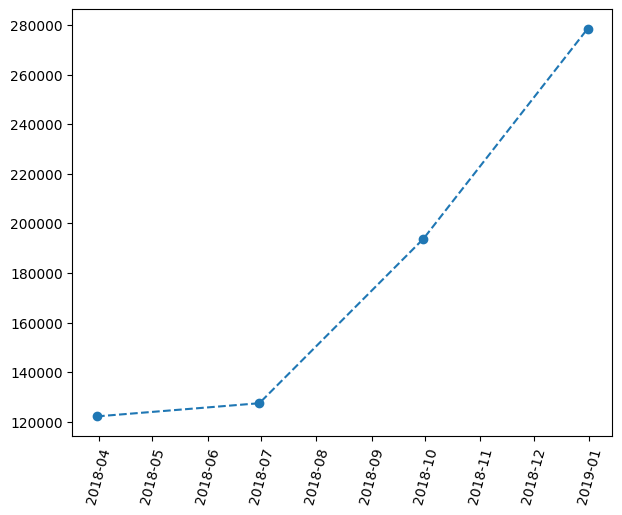

In [79]:

plt.plot(quarterly_sales['Quarter'], quarterly_sales['Total Sales'], marker = 'o', linestyle = '--')

plt.tight_layout()
plt.xticks(rotation=75)
plt.show()

In [80]:
df['Order Date'] = pd.to_datetime(df['Order Date'], dayfirst = True)
yearly_sales = df[df['Order Date'].dt.year == 2018]
monthly_sales = yearly_sales.resample('M', on = 'Order Date')['Sales'].sum()
monthly_sales = monthly_sales.reset_index()
monthly_sales = monthly_sales.rename(columns={'Order Date':'Month', 'Sales' : 'Total Monthly Sales'})

print (monthly_sales)

        Month  Total Monthly Sales
0  2018-01-31           43476.4740
1  2018-02-28           19920.9974
2  2018-03-31           58863.4128
3  2018-04-30           35541.9101
4  2018-05-31           43825.9822
5  2018-06-30           48190.7277
6  2018-07-31           44825.1040
7  2018-08-31           62837.8480
8  2018-09-30           86152.8880
9  2018-10-31           77448.1312
10 2018-11-30          117938.1550
11 2018-12-31           83030.3888


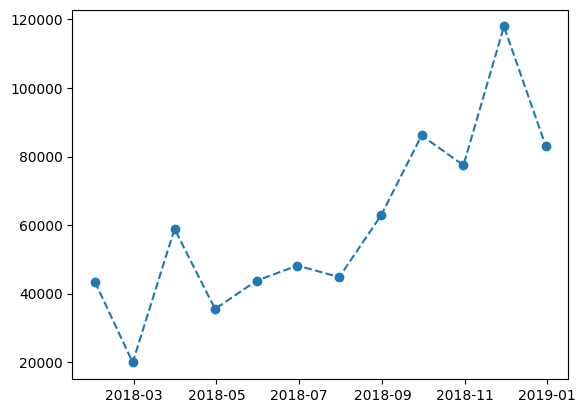

In [81]:
plt.plot(monthly_sales['Month'], monthly_sales['Total Monthly Sales'], marker = 'o', linestyle = '--')